# 1. Понимание бизнеса

## 1.1 Цель
Wine Quality

## 1.2 Описание
Data Set Information:

The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 20, 10

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( df[ var ].min() , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp.plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [3]:
wine = pd.read_csv('winequalityN.csv')
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## 2.4 Статистика и визуализации

In [4]:
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Attribute Information:**

For more information, read [Cortez et al., 2009].

Input variables (based on physicochemical tests):
* 1 - fixed acidity
* 2 - volatile acidity
* 3 - citric acid
* 4 - residual sugar
* 5 - chlorides
* 6 - free sulfur dioxide
* 7 - total sulfur dioxide
* 8 - density
* 9 - pH
* 10 - sulphates
* 11 - alcohol

Output variable (based on sensory data):
* 12 - quality (score between 0 and 10)

[Больше информации на сайте Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

In [5]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

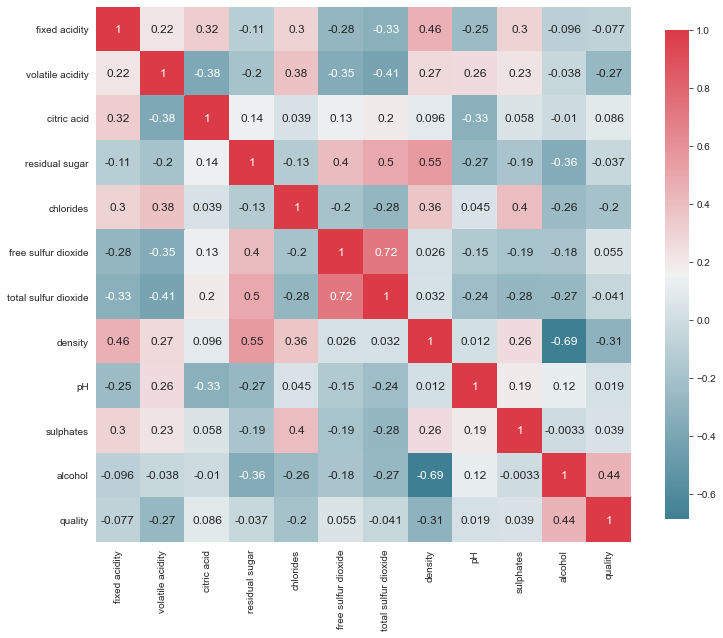

In [6]:
plot_correlation_map(wine)

Видно, что качество вина коррелирует с количеством алкоголя. Проверим на графике:

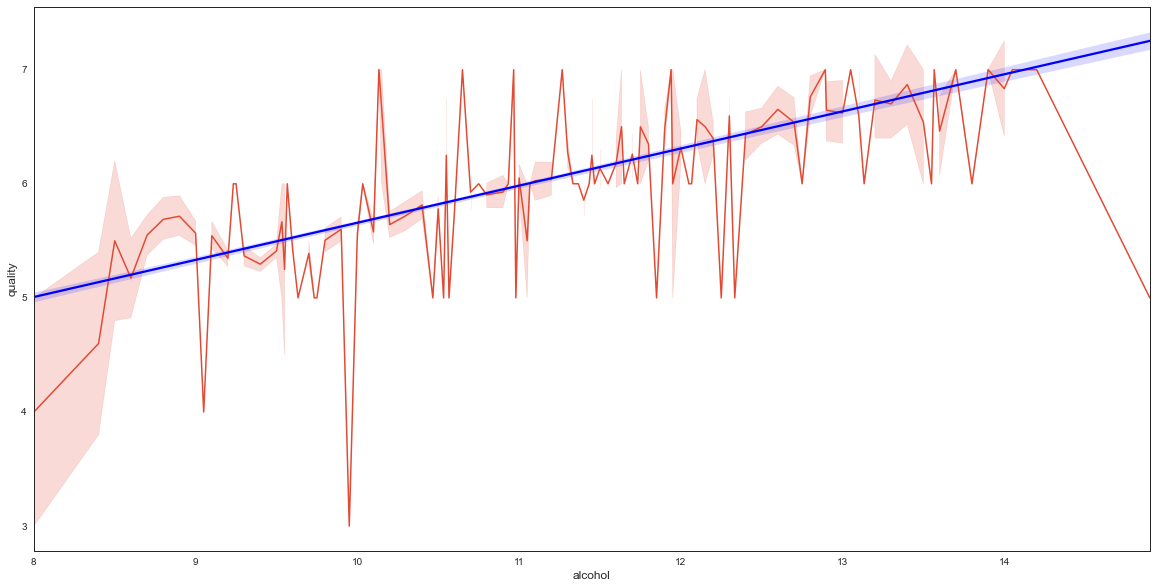

In [7]:
ax1 = sns.lineplot(data=wine, x="alcohol", y="quality")
ax2 = sns.regplot(data=wine, x="alcohol", y="quality", scatter=False, line_kws={"color": "blue"})

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между содержанием алкоголя и качеством вина

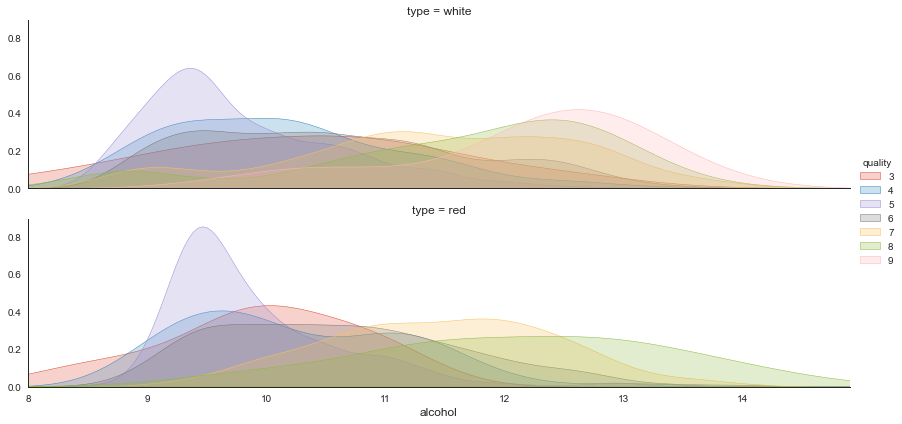

In [8]:
plot_distribution( wine , var = 'alcohol' , target = 'quality' , row = 'type' )

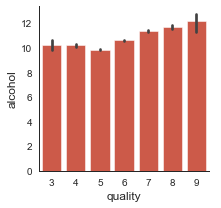

In [9]:
# Plot alcohol level by quality
plot_categories( wine , cat = 'quality' , target = 'alcohol' )

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

In [10]:
wine = pd.get_dummies(wine)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [11]:
df = wine.isnull().any().to_frame()
nan_col_names = df[df[0] == True].index
nan_col_names

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'pH', 'sulphates'],
      dtype='object')

In [12]:
for col in nan_col_names:
    median = wine[col].median()
    wine[col] = wine[col].fillna(median)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## 3.3 Feature Engineering &ndash; добавляем новые признаки

## 3.4 Сборка финальных датасетов для моделирования

In [13]:
train_valid_X = wine.drop('quality', axis=1)
train_valid_y = wine['quality']
train_valid_X.shape, train_valid_y.shape

((6497, 13), (6497,))

### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [14]:
# Create all datasets that are necessary to train, validate and test models
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (train_X.shape , valid_X.shape , train_y.shape , valid_y.shape)

(4547, 13) (1950, 13) (4547,) (1950,)


### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

In [15]:
train_X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
3302,6.6,0.240,0.28,6.7,0.032,26.0,91.0,0.99172,3.13,0.32,12.3,0,1
6368,10.0,0.690,0.11,1.4,0.084,8.0,24.0,0.99578,2.88,0.47,9.7,1,0
5016,8.8,0.550,0.04,2.2,0.119,14.0,56.0,0.99620,3.21,0.60,10.9,1,0
1951,9.9,1.005,0.46,1.4,0.046,34.0,185.0,0.99660,3.02,0.49,10.2,0,1
5918,11.3,0.360,0.66,2.4,0.123,3.0,8.0,0.99642,3.20,0.53,11.9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5922,7.7,0.580,0.01,1.8,0.088,12.0,18.0,0.99568,3.32,0.56,10.5,1,0
594,6.4,0.475,0.06,1.0,0.030,9.0,131.0,0.99040,2.97,0.29,10.8,0,1
871,7.7,0.340,0.58,11.1,0.039,41.0,151.0,0.99780,3.06,0.49,8.6,0,1
4766,6.4,0.320,0.25,5.0,0.055,28.0,138.0,0.99171,3.27,0.50,12.4,0,1


1.0


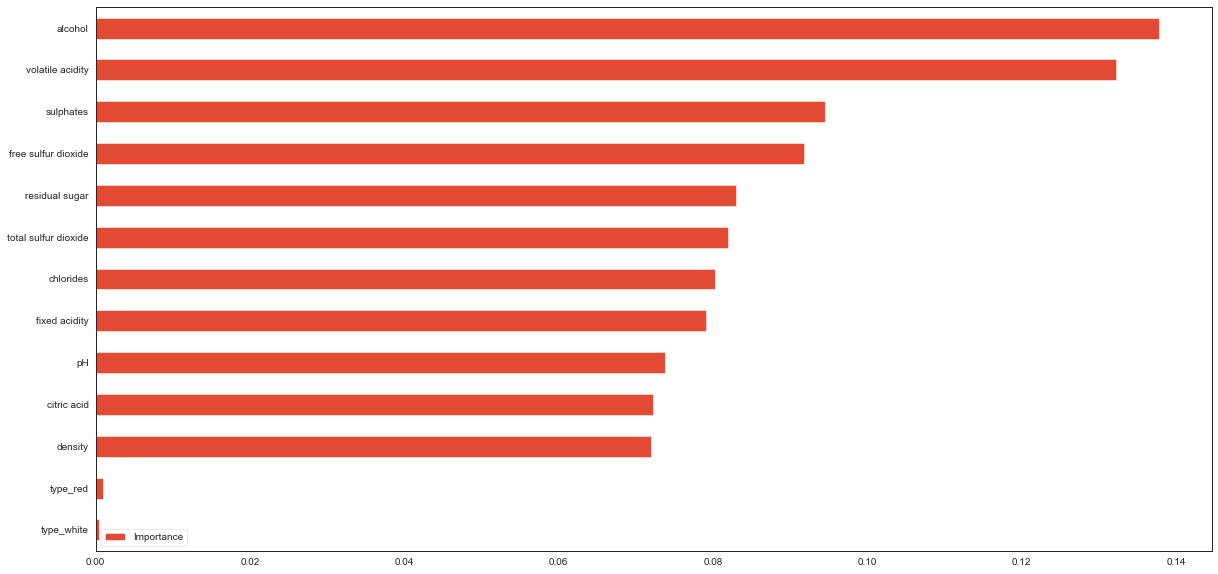

In [16]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [17]:
models = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    LinearSVC(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

for model in models:
    model.fit( train_X, train_y )
    # Score the model
    train_score = model.score( train_X , train_y )
    valid_score = model.score( valid_X , valid_y )
    print (model.__class__.__name__, train_score, valid_score)

DecisionTreeClassifier 1.0 0.5902564102564103
LogisticRegression 0.48119639322630303 0.45692307692307693
KNeighborsClassifier 0.6459203870683967 0.45794871794871794
GaussianNB 0.32812843633164723 0.31743589743589745
SVC 0.44908731031449306 0.4158974358974359
LinearSVC 0.31603254893336263 0.34102564102564104
RandomForestClassifier 1.0 0.6574358974358975
GradientBoostingClassifier 0.6780294699802067 0.5528205128205128


Лучше всего работает RandomForestClassifier, но видно, что он переобучен. Поэтому выберем GradientBoostingClassifier

# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

В нашей задаче это не требуется, т.к. нет тестового датасета